In [1]:
import os,sys
from pmtool.ToolBox import ToolBox
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

%matplotlib inline

In [3]:
parameters = {'data_path': r'E:\Internship Mass storage\First 3 datasets\Duke_breast_MRI dataset\Testfiles', # path to your DICOM data
              'data_type': 'dcm', # original data format: DICOM
              'multi_rts_per_pat': False,
              'image_only' : True}   # when False, it will look only for 1 rtstruct in the patient folder, 
                                            # this will speed up the process, 
                                            # if you have more then 1 rtstruct per patient, set it to True
data_dcms = ToolBox(**parameters)

100%|██████████| 3/3 [00:00<00:00, 150.65it/s]


In [4]:
dataset_description = data_dcms.get_dataset_description() 
dataset_description.head(10)

Patients processed: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


,Modality,SliceThickness,PixelSpacing,SeriesDate,Manufacturer,patient,slice#
0,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,0
1,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,1
2,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,2
3,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,3
4,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,4
5,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,5
6,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,6
7,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,7
8,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,8
9,MR,1.1,"[0.80357140302658, 0.80357140302658]",19900101,SIEMENS,Breast_MRI_001,9


In [5]:
print('Unique modalities found: ', np.unique(dataset_description.Modality.values)[0])

Unique modalities found:  MR


In [6]:
MRI_dcms = ToolBox(**parameters)
dataset_description = MRI_dcms.get_dataset_description('MRI') 
dataset_description.head(10)

Patients processed: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


,Manufacturer,SliceThickness,PixelSpacing,StudyDate,MagneticFieldStrength,EchoTime,patient,slice#
0,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,0
1,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,1
2,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,2
3,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,3
4,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,4
5,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,5
6,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,6
7,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,7
8,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,8
9,SIEMENS,1.1,"[0.80357140302658, 0.80357140302658]",19900101,1.5,1.36,Breast_MRI_001,9


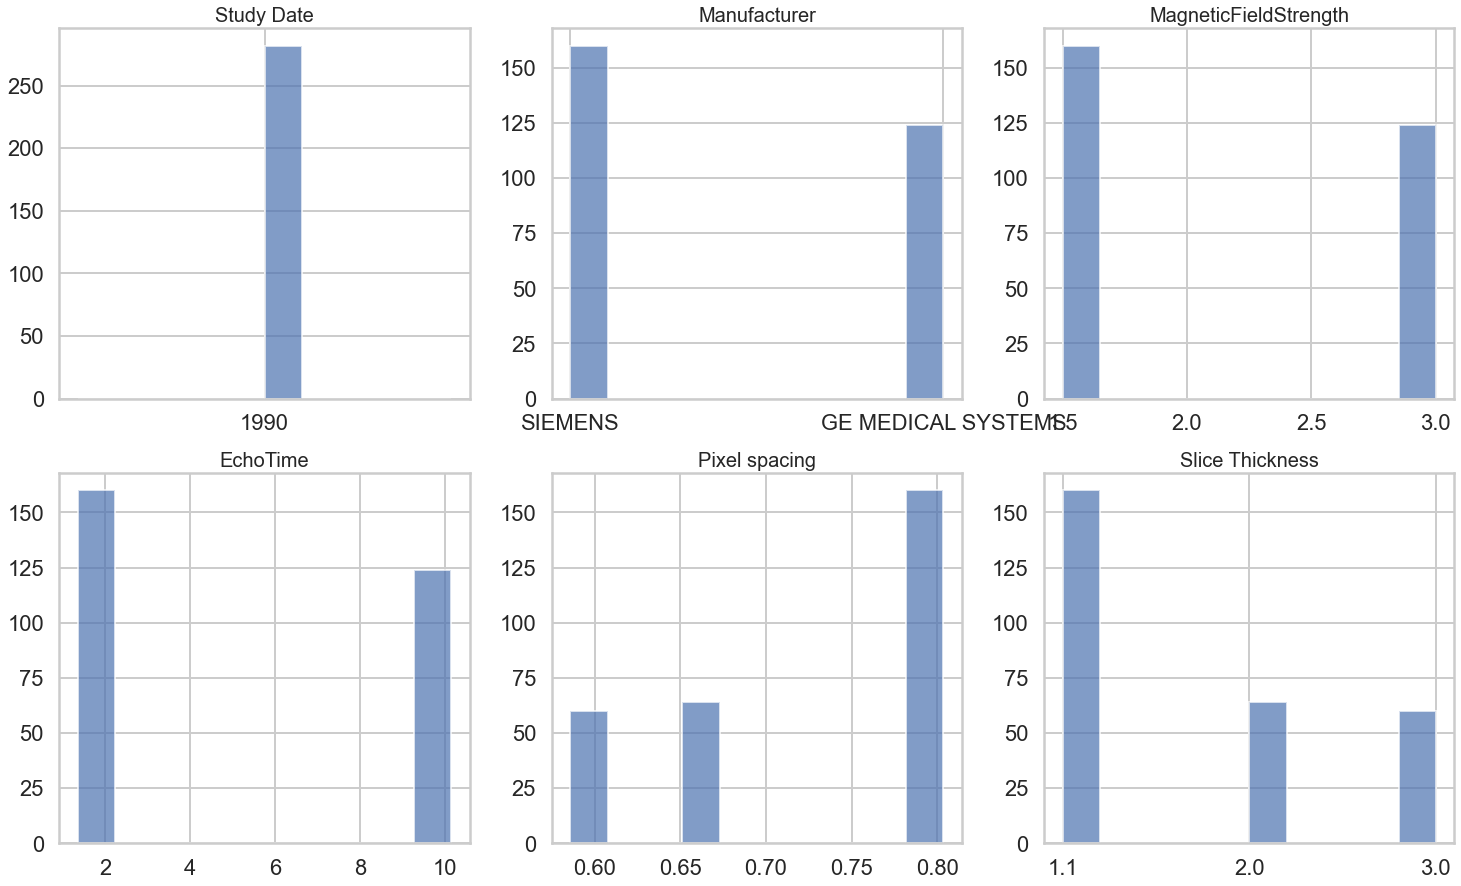

In [10]:
sb.set(context='poster', style='whitegrid')
#changed some of these to fit this dataset
study_date = sorted([ 'Nan' if x=='' or x=='NaN' else str(x[0:4]) for x in list(dataset_description['StudyDate'])])[2:]
manu =['Nan' if x=='' or x=='NaN' else x for x in list(dataset_description['Manufacturer'])]
magfield_strength =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['MagneticFieldStrength'])]
echot =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['EchoTime'])]
ps = sorted([(x[0]) for x in list(filter(lambda x: x != 'NaN', dataset_description['PixelSpacing'].values))])
sl_th = sorted([str(x)[0:3] for x in list(filter(lambda x: x != 'NaN', dataset_description['SliceThickness'].values))])
figures,descriptions = [study_date,manu,magfield_strength,echot,ps,sl_th],['Study Date','Manufacturer','MagneticFieldStrength','EchoTime','Pixel spacing','Slice Thickness']

fig,ax = plt.subplots(2,3,figsize=(25,15))
for i in range(2):
    for j in range(3):
        ax[i,j].hist(figures.pop(0),alpha=0.7)
        ax[i,j].set_title(descriptions.pop(0),fontsize=20)

In [14]:
qc_params = {'specific_modality': 'MR', # target modality: CT
            'thickness_range': [1,2], # slice thickness should be in range of 2..5 mm (changed to 1-2 for this set)
            'spacing_range': [0.5,1.25], # pixel spacing should be in range of 0.5..1.25 mm
            'scan_length_range': [5,170], # scan should contain from 5 to 170 slices
            'axial_res': [512,512], # the axial resolution should be 512x512
            'kernels_list': ['standard','lung','b19f']} # the following kernels are acceptable

In [15]:
qc_dataframe = MRI_dcms.get_quality_checks(qc_params)

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\MegaMert\Documents\GitHub\precision-medicine-toolbox\pmtool\ToolBox.py:559: UserWarning: Problems occured with rescaling intensities
  warn('Problems occured with rescaling intensities')
 67%|██████▋   | 2/3 [00:00<00:00,  4.41it/s]

Cannot perform conv kernel check for pat: Breast_MRI_001
Cannot perform conv kernel check for pat: Breast_MRI_002


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

Cannot perform conv kernel check for pat: Breast_MRI_003


In [16]:
qc_dataframe

,Patient id,Modality is acceptable,Projection is axial,Complete scan (no missing/overlapping slices),Scan len is in range,Slice thickness is in range,Slice thickness is consistent,Pixel spacing is in range,Convolutional kernel tag is present,Convolutional kernel is acceptable,Axial pr. resolution is acceptable,Intensity intercept/slope tags are present
0,Breast_MRI_001,1,0,0,1,1,1,1,0,NaN,0,0
1,Breast_MRI_002,1,1,1,1,0,1,1,0,NaN,0,0
2,Breast_MRI_003,1,1,1,1,1,1,1,0,NaN,0,0


In [17]:
export_path = r'C:\Users\MegaMert\Desktop\Internship files\Tutorial data\Converted'
region_of_interest = 'all'
data_ct = ToolBox(**parameters) 


100%|██████████| 3/3 [00:00<00:00, 143.25it/s]


In [18]:
data_ct.convert_to_nrrd(export_path)

Patients converted:   0%|          | 0/3 [00:00<?, ?it/s]


IndexError: list index out of range

In [ ]:
data_ct_nrrd = ToolBox(data_path = r'C:\Users\MegaMert\Desktop\Internship files\Tutorial data\Converted\Test', data_type='nrrd')


In [ ]:
data_ct_nrrd.get_jpegs(r'C:\Users\MegaMert\Desktop\Internship files\Tutorial data\Converted') # the function will create 'images_quick_check' folder in the specified directory 

In [ ]:
from ipywidgets import interact
import numpy as np
from PIL import Image

def browse_images(images,names):
    n = len(images)
    def view_image(i):
        plt.figure(figsize=(20,10))
        plt.imshow(images[i])#, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Slice: %s' % names[i])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))

for pat,_ in data_ct_nrrd:
    _,file_struct = [*os.walk(os.path.join(r'C:\Users\MegaMert\Desktop\Internship files\Tutorial data\Converted\images_quick_check',pat))]
    root,images = file_struct[0],file_struct[2]
    imgs =[np.array(Image.open(os.path.join(root,img))) for img in images]
    print(pat)
    browse_images(imgs,images)
    break

In [ ]:
parameters = r"C:\Users\MegaMert\Documents\GitHub\precision-medicine-toolbox\examples\example_ct_parameters.yaml"
features = data_ct_nrrd.extract_features(parameters, loggenabled=True)

In [ ]:
sb.set(context='poster', style='white')
data_ct_nrrd.pre_process(ref_img_path = r'C:\Users\MegaMert\Desktop\Internship files\Tutorial data\Converted\converted_nrrds\LUNG1-001_1-1\image.nrrd',
                         save_path = r'C:\Users\MegaMert\Desktop\Internship files\Tutorial data\Converted\Preprocessed',
                         hist_match = False,        # boolean
                         subcateneus_fat = False,   # boolean
                         fat_value = 774,           # this is a dummy value, 
                                                    # you would need to find that value for each image
                         percentile_scaling = False, # boolean
                         window_filtering_params = (1500,-600), #Window Filtering [WW,WL]
                         binning = 255,             # this is a dummy value, it takes False or int 
                                                    # (# of bins for intensity resampling)
                         verbosity = True,          # boolean
                         z_score = True,           # boolean 
                         hist_equalize = True,     # boolean
                         norm_coeff = (1000.,500.), # these are dummy values, you would need to estimate real mu and sigma
                                                    # it takes None or tuple: (mu,sigma)
                         visualize = True)

In [ ]:
features.head(3)

In [ ]:
writer = pd.ExcelWriter(r'C:\Users\MegaMert\Documents\GitHub\precision-medicine-toolbox\data/features/extracted_features.xlsx') 
features.to_excel(writer, 'Sheet1')
writer.save()